#The Battle of Neighborhoods
##Finding similar neighborhoods in Kyiv

##Introduction
The rental market is very mobile. This question becomes especially relevant during a pandemic:
* move closer to work, so as not to use transport, 
* on the contrary, move further from the center in connection with remote work,
* find a more comfortable and larger apartment because they began to spend more time at home
* change apartment to house.

For all these questions, it is very convenient to be able to compare different neighborhoods in order to choose one that is similar in infrastructure to the one where you lived before, but in a different part of the city.

##Data
We will consider the solution of the problem using the example of the city of Kyiv, Ukraine.
To solve the described problem, we need the following data:
* geodata for dividing the city into areas (opencagedata.com)
* venues of each region (data from Foursquare)
* information on the location of metro stations (Wikipedia).
* information on the index of real estate prices (data of real estate rental portals).

In [ ]:
import pandas as pd
import numpy as np
import math
import requests
import json
import geopy.distance

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

###Get areas


We will use the coordinates of Saint Sophia Cathedral in Kyiv as the city center.

In [ ]:
latitude = 50.452780
longitude = 30.514440

We will consider a zone with a radius of about 10 km around the center of Kiev. Divide it into sectors with a diameter of 1 km and calculate the coordinates of the center of each sector.

In [ ]:
delta_lat = 360/40075
delta_lon = 360/(math.cos(math.radians(latitude))*40075)

latitudes=[]
longitudes=[]

for i in range(-10, 11):
  for j in range(-10, 11):
    latitudes.append(latitude + delta_lat*i)
    longitudes.append(longitude + delta_lon*j)

In [ ]:
Kyiv_coords = pd.DataFrame(list(zip(latitudes, longitudes)), columns =['latitude', 'longitude'])

Kyiv_coords.shape

(441, 2)

We got 441 areas. We need to identify them.
For each region, we will define its address and district. To do this, we will use the API https://opencagedata.com/. In addition, some areas lie outside the city, such areas need to be removed from the data.

In [ ]:
def getAdr(latitudes, longitudes):
    
    addresses_list=[]
    for lat, lng in zip(latitudes, longitudes):
                    
        # create the API request URL
        url='https://api.opencagedata.com/geocode/v1/json?q={},{}&language=en&key={}'.format(
            lat, 
            lng, 
            Token)
            
        # make the GET request
        results = requests.get(url).json()['results'][0]
        #print(results)

        # if we are outside of Kiev, there will be no 'city' parameter
        if 'city' in results['components']:

          if 'road' in results['components']:
            address = results['components']['road']
            if 'house_number' in results['components']:
              address = address + ', ' + results['components']['house_number']
          else:
            address = results['formatted']

          addresses_list.append([
              address,
              results['components']['borough'],
              results['components']['city'],
              lat,
              lng])

    addresses = pd.DataFrame(addresses_list, columns=['Address', 'Neighborhood', 'City', 'Latitude', 'Longitude'])
    
    return(addresses)

In [ ]:
Kyiv_addresses = getAdr(latitudes=Kyiv_coords['latitude'], longitudes=Kyiv_coords['longitude'])

In [ ]:
Kyiv_addresses[20:30]

,Address,Neighborhood,City,Latitude,Longitude
20,Спуск Ельдорадо,Holosiivskyi District,Kyiv,50.371932,30.500331
21,"Myshalivka, Kyiv, 03041, Ukraine",Holosiivskyi District,Kyiv,50.371932,30.514440
22,"Akademika Kashchenka Street, 33",Holosiivskyi District,Kyiv,50.371932,30.528549
23,"Nauky Avenue, 88а",Holosiivskyi District,Kyiv,50.371932,30.542657
24,Halerna Street,Holosiivskyi District,Kyiv,50.371932,30.556766
25,Halerna Street,Holosiivskyi District,Kyiv,50.371932,30.570874
26,75th Sadova Street,Darnytskyi district,Kyiv,50.371932,30.584983
27,"Kyiv, 02132, Ukraine",Darnytskyi district,Kyiv,50.371932,30.599092
28,71st Sadova Street,Darnytskyi district,Kyiv,50.371932,30.613200
29,6th Pivnichno-Ozernyi Lane,Darnytskyi district,Kyiv,50.371932,30.627309


In [ ]:
Kyiv_addresses.to_csv('Kyiv_addresses.csv')

###Distance to city center
One of the important criteria when choosing a place of residence is the distance to the city center. Let's calculate ago for each of the area.
The latitude and longitude of the city center are already defined above.

In [ ]:
dist_list = []
for i, address in Kyiv_addresses.iterrows():
  lat = address['Latitude']
  lon = address['Longitude']
  dist_list.append(geopy.distance.vincenty((lat,lon), (latitude, longitude)).km)

In [ ]:
Kyiv_addresses['Distance to center'] = dist_list

In [ ]:
Kyiv_addresses[140:145]

,Address,Neighborhood,City,Latitude,Longitude,Distance to center
140,"Pavla Tychyny Avenue, 14б",Dniprovskyi district,Kyiv,50.425831,30.599092,6.719463
141,Berezniakivska Street,Dniprovskyi district,Kyiv,50.425831,30.613200,7.629584
142,Darnytske Road,Darnytskyi district,Kyiv,50.425831,30.627309,8.560319
143,"Kharkivske Road, 21/3",Darnytskyi district,Kyiv,50.425831,30.641418,9.505614
144,"Novodarnytska Street, 15",Darnytskyi district,Kyiv,50.425831,30.655526,10.461523


###Distance to the nearest metro station
Let's take a list of metro stations with coordinates of their location and determine the nearest metro station to each of the regions.

In [ ]:
Kyiv_metro = pd.DataFrame([['Akademmistechko', 50.464861, 30.355083],
                          ['Zhytomyrska', 50.456175, 30.365628],
                          ['Sviatoshyn', 50.457903, 30.390614],
                          ['Nyvky', 50.458653, 30.404042],
                          ['Beresteiska', 50.458333, 30.420833],
                          ['Shuliavska', 50.455, 30.445278], 
                          ['Politekhnichnyi Instytut', 50.450833, 30.466111], 
                          ['Vokzalna', 50.441667, 30.4875], 
                          ['Universytet', 50.444167, 30.505833], 
                          ['Teatralna', 50.444722, 30.518056], 
                          ['Khreshchatyk', 50.447222, 30.523333], 
                          ['Arsenalna', 50.443889, 30.545556], 
                          ['Hidropark', 50.445556, 30.576944], 
                          ['Livoberezhna', 50.451389, 30.598889], 
                          ['Darnytsia', 50.455556, 30.613056], 
                          ['Chernihivska', 50.459722, 30.630833], 
                          ['Lisova', 50.464639, 30.645556], 
                          ['Heroiv Dnipra', 50.5225, 30.498611], 
                          ['Minska', 50.512222, 30.498333], 
                          ['Obolon', 50.501111, 30.498056], 
                          ['Pochaina', 50.486667, 30.497778], 
                          ['Tarasa Shevchenka', 50.473056, 30.505], 
                          ['Kontraktova Ploshcha', 50.465, 30.516667], 
                          ['Poshtova Ploshcha', 50.459167, 30.525556], 
                          ['Maidan Nezalezhnosti', 50.45, 30.524167], 
                          ['Ploshcha Lva Tolstoho', 50.439444, 30.516944],
                          ['Olimpiiska', 50.431944, 30.516389],
                          ['Palats Ukrayina', 50.420833, 30.520833], 
                          ['Lybidska', 50.420833, 30.520833], 
                          ['Demiivska', 50.404792, 30.516833], 
                          ['Holosiivska', 50.3975, 30.508333], 
                          ['Vasylkivska', 50.393333, 30.488056], 
                          ['Vystavkovyi Tsentr', 50.382581, 30.477536], 
                          ['Ipodrom', 50.376556, 30.469117], 
                          ['Teremky', 50.367044, 30.454203], 
                          ['Syrets', 50.476111, 30.430556], 
                          ['Dorohozhychi', 50.473611, 30.449444], 
                          ['Lukianivska', 50.462222, 30.481667], 
                          ['Zoloti Vorota', 50.448333, 30.513333], 
                          ['Palats Sportu', 50.438056, 30.520833], 
                          ['Klovska', 50.436944, 30.531667], 
                          ['Pecherska', 50.4275, 30.538889], 
                          ['Druzhby Narodiv', 50.418056, 30.545], 
                          ['Vydubychi', 50.402222, 30.560833], 
                          ['Slavutych', 50.394167, 30.604167], 
                          ['Osokorky', 50.395278, 30.616111], 
                          ['Pozniaky', 50.398056, 30.633333], 
                          ['Kharkivska', 50.400833, 30.652222], 
                          ['Vyrlytsia', 50.403333, 30.666111], 
                          ['Boryspilska', 50.403333, 30.682778], 
                          ['Chervony Khutir', 50.408889, 30.694444]], columns=['Metro Station', 'Latitude', 'Longitude'])

In [ ]:
station_list = []
min_dist = []
for i, address in Kyiv_addresses.iterrows():
  lat = address['Latitude']
  lon = address['Longitude']
  mind = geopy.distance.vincenty((lat,lon), (Kyiv_metro.at[0, 'Latitude'],Kyiv_metro.at[0, 'Longitude'])).km
  minst = Kyiv_metro.at[0, 'Metro Station']
  for j, station in Kyiv_metro.iterrows():
    lat_st = station['Latitude']
    lon_st = station['Longitude']
    
    #distance in kilometers
    dist = geopy.distance.vincenty((lat,lon), (lat_st,lon_st)).km
    if dist < mind:
      mind = dist
      minst = station['Metro Station']
  min_dist.append(mind)
  station_list.append(minst)

Let's add the received lists to our addresses.

In [ ]:
Kyiv_addresses['Metro Station'] = station_list
Kyiv_addresses['Metro_dist'] = min_dist

In [ ]:
Kyiv_addresses[170:175]

,Address,Neighborhood,City,Latitude,Longitude,Distance to center,Metro Station,Metro_dist
170,Аттили Могильного вулиця,Solomianskyi district,Kyiv,50.443797,30.429788,6.095020,Shuliavska,1.662349
171,"Industrialnyi Lane, 2",Solomianskyi district,Kyiv,50.443797,30.443897,5.109130,Shuliavska,1.250068
172,Dashavska Street,Solomianskyi district,Kyiv,50.443797,30.458006,4.131044,Politekhnichnyi Instytut,0.971622
173,"Umanska Street, 6Ф",Solomianskyi district,Kyiv,50.443797,30.472114,3.167999,Politekhnichnyi Instytut,0.891295
174,"Starovokzalna Street, 25",Shevchenkivskyi district,Kyiv,50.443797,30.486223,2.239482,Vokzalna,0.253697


###Price index

Let's take the cost of one square meter of housing in Kiev, depending on the metro station, normalize this data and add it to the list of addresses.
Cost per square meter https://stroyobzor.ua/news/ceny-na-kvartiry-v-stolice-v-zavisimosti-ot-stancii-metro-oktyabr-2020.html

In [ ]:
Kyiv_cost_per_m = pd.DataFrame([['Akademmistechko', 20921],
                          ['Zhytomyrska', 29428],
                          ['Sviatoshyn', 27222],
                          ['Nyvky', 31530],
                          ['Beresteiska', 26754],
                          ['Shuliavska', 23226], 
                          ['Politekhnichnyi Instytut', 45390], 
                          ['Vokzalna', 37846], 
                          ['Universytet', 57417], 
                          ['Teatralna', 57417], 
                          ['Khreshchatyk', 148188], 
                          ['Arsenalna', 74167], 
                          ['Hidropark', 49612], 
                          ['Livoberezhna', 25729], 
                          ['Darnytsia', 25331], 
                          ['Chernihivska', 23980], 
                          ['Lisova', 25787], 
                          ['Heroiv Dnipra', 25793], 
                          ['Minska', 51025], 
                          ['Obolon', 34048], 
                          ['Pochaina', 24439], 
                          ['Tarasa Shevchenka', 44025], 
                          ['Kontraktova Ploshcha', 39633], 
                          ['Poshtova Ploshcha', 32690], 
                          ['Maidan Nezalezhnosti', 148188], 
                          ['Ploshcha Lva Tolstoho', 70000],
                          ['Olimpiiska', 65312],
                          ['Palats Ukrayina', 51590], 
                          ['Lybidska', 48538], 
                          ['Demiivska', 26252], 
                          ['Holosiivska', 35823], 
                          ['Vasylkivska', 25151], 
                          ['Vystavkovyi Tsentr', 32000], 
                          ['Ipodrom', 27931], 
                          ['Teremky', 24028], 
                          ['Syrets', 23848], 
                          ['Dorohozhychi', 31403], 
                          ['Lukianivska', 36888], 
                          ['Zoloti Vorota', 57417], 
                          ['Palats Sportu', 70000], 
                          ['Klovska', 105330], 
                          ['Pecherska', 63312], 
                          ['Druzhby Narodiv', 56718], 
                          ['Vydubychi', 23540], 
                          ['Slavutych', 26057], 
                          ['Osokorky', 28865], 
                          ['Pozniaky', 22667], 
                          ['Kharkivska', 24467], 
                          ['Vyrlytsia', 23957], 
                          ['Boryspilska', 22474], 
                          ['Chervony Khutir', 24745]], columns=['Metro Station', 'Cost per square meter'])

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Cost = Kyiv_cost_per_m['Cost per square meter'].values.reshape(-1,1)
Cost = sc.fit_transform(Cost, )
Kyiv_cost_per_m['Cost per square meter'] = Cost

Kyiv_cost_per_m.head()

,Metro Station,Cost per square meter
0,Akademmistechko,-0.789293
1,Zhytomyrska,-0.481102
2,Sviatoshyn,-0.561021
3,Nyvky,-0.404950
4,Beresteiska,-0.577975


In [ ]:
Kyiv_addresses=Kyiv_addresses.merge(Kyiv_cost_per_m)

In [ ]:
Kyiv_addresses.rename(columns={'Cost per square meter': 'Price index'}, inplace=True)
Kyiv_addresses[125:130]

,Address,Neighborhood,City,Latitude,Longitude,Distance to center,Metro Station,Metro_dist,Price index
125,Druzhby Narodiv Boulevard,Pecherskyi district,Kyiv,50.416847,30.542657,4.471629,Druzhby Narodiv,0.214009,0.507561
126,"Zvirynets, Kyiv, 01014, Ukraine",Pecherskyi district,Kyiv,50.416847,30.556766,5.001925,Druzhby Narodiv,0.846974,0.507561
127,Staronavodnytska Street,Pecherskyi district,Kyiv,50.425831,30.556766,4.245923,Druzhby Narodiv,1.202941,0.507561
128,Naberezhne Road,Pecherskyi district,Kyiv,50.425831,30.570874,5.005980,Druzhby Narodiv,2.032021,0.507561
129,Kachalova Street,Sviatoshynskyi district,Kyiv,50.416847,30.415680,8.075243,Beresteiska,4.629257,-0.577975


In [ ]:
# create map of Kyiv using latitude and longitude values
map_Kyiv = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lon in zip(Kyiv_addresses['Latitude'], Kyiv_addresses['Longitude']):
    folium.Circle([lat, lon], radius=500, color='yellow', fill=False).add_to(map_Kyiv)   
map_Kyiv

###Venues of each region (from Foursquare)

In order not to miss the zones between the circles, increase the radius by the root of two. We will delete any possible duplicates after creating a directory of establishments.

In [ ]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
RADIUS = 500*math.sqrt(2) # define radius

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Address', 
                  'Address Latitude', 
                  'Address Longitude', 
                  'Venue ID',
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
Kyiv_venues = getNearbyVenues(names=Kyiv_addresses['Address'],
                                   latitudes=Kyiv_addresses['Latitude'],
                                   longitudes=Kyiv_addresses['Longitude']
                                  )

Delete duplicates by Venue ID

In [ ]:
Kyiv_venues.drop_duplicates(subset=['Venue ID'], inplace=True)
Kyiv_venues.head()

,Address,Address Latitude,Address Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Akademika Hlushkova Avenue,50.362948,30.443897,4fa0315ae4b0dc03c72a1e1d,Урочище «Теремки» (ліс Шмальгаузена),50.363313,30.451183,Forest
1,Akademika Hlushkova Avenue,50.362948,30.443897,51f297c7498ecbcd7ce958ab,"Гриль-паб ""КуСай""",50.361583,30.444024,BBQ Joint
2,Akademika Hlushkova Avenue,50.362948,30.443897,5058081de4b0db00fc0871f0,Зупинка «Кібернетичний центр»,50.361706,30.444877,Bus Stop
3,Akademika Hlushkova Avenue,50.362948,30.443897,520de49311d2c41539dd317a,Restorio,50.361631,30.446598,Restaurant
4,Akademika Hlushkova Avenue,50.362948,30.443897,4f11ab8fe4b0a6ade07e42be,Полуничка,50.360584,30.444413,Café


In [ ]:
Kyiv_venues.to_csv('Kyiv_venues.csv')

In [ ]:
Kyiv_venues.shape

(6881, 8)

In [ ]:
len(Kyiv_venues['Venue Category'].unique())

429

There are 429 categories of venues. For a more correct analysis, we will introduce the top-level categories.

In [ ]:
Categories = pd.read_csv('Categories.csv')

In [ ]:
Categories.head()

,Venue Category,primary
0,Museum,Art
1,Forest,Recreation
2,Fountain,Recreation
3,Irish Pub,Food
4,Eastern European Restaurant,Food


In [ ]:
Kyiv_venues = Kyiv_venues.merge(Categories)

In [ ]:
Kyiv_venues.groupby('primary').count()

,Address,Address Latitude,Address Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,RegionID
primary,,,,,,,,,
Art,141,141,141,141,141,141,141,141,141
Education,49,49,49,49,49,49,49,49,49
Entertainment,222,222,222,222,222,222,222,222,222
Food,1754,1754,1754,1754,1754,1754,1754,1754,1754
Medical Center,75,75,75,75,75,75,75,75,75
Playground,45,45,45,45,45,45,45,45,45
Professional & Other,25,25,25,25,25,25,25,25,25
Recreation,737,737,737,737,737,737,737,737,737
Service,324,324,324,324,324,324,324,324,324


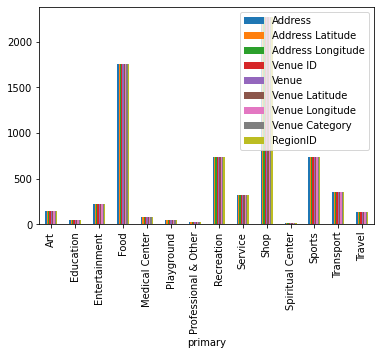

In [ ]:
Kyiv_venues.groupby('primary').count().plot(kind='bar')

In [ ]:
concat = lambda s1, s2: str(s1) + str(s2)
Kyiv_addresses['RegionID']=Kyiv_addresses['Latitude'].combine(Kyiv_addresses['Longitude'], concat)
Kyiv_venues['RegionID'] = Kyiv_venues['Address Latitude'].combine(Kyiv_venues['Address Longitude'], concat)

In [ ]:
# one hot encoding
Kyiv_onehot = pd.get_dummies(Kyiv_venues[['primary']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Kyiv_onehot['RegionID'] = Kyiv_venues['RegionID'] 

# move neighborhood column to the first column
fixed_columns = [Kyiv_onehot.columns[-1]] + list(Kyiv_onehot.columns[:-1])
Kyiv_onehot = Kyiv_onehot[fixed_columns]

Kyiv_onehot.head()

,RegionID,Art,Education,Entertainment,Food,Medical Center,Playground,Professional & Other,Recreation,Service,Shop,Spiritual Center,Sports,Transport,Travel
0,50.36294843418589630.44389688717384,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,50.36294843418589630.472114132304306,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,50.36294843418589630.486222754869537,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,50.3719315907673130.50033137743477,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,50.36294843418589630.528548622565232,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
Kyiv_grouped = Kyiv_onehot.groupby('RegionID').mean().reset_index()

In [ ]:
Kyiv_grouped = Kyiv_grouped.merge(Kyiv_addresses[['RegionID', 'Distance to center',	'Metro_dist',	'Price index']])

In [ ]:
Kyiv_grouped.describe()

,Art,Education,Entertainment,Food,Medical Center,Playground,Professional & Other,Recreation,Service,Shop,Spiritual Center,Sports,Transport,Travel,Distance to center,Metro_dist,Price index
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,0.015339,0.005632,0.025773,0.190755,0.006863,0.008710,0.011587,0.228624,0.047850,0.245852,0.000725,0.110098,0.085526,0.016666,7.570126,2.333470,-0.377375
std,0.053771,0.023219,0.075567,0.161504,0.020837,0.056929,0.080291,0.293532,0.092429,0.205697,0.008598,0.143775,0.141898,0.048979,2.800195,1.690619,0.537954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.155400,-0.789293
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.659898,0.973998,-0.661843
50%,0.000000,0.000000,0.000000,0.197561,0.000000,0.000000,0.000000,0.105823,0.000000,0.262788,0.000000,0.071429,0.000000,0.000000,8.015972,1.896973,-0.612791
75%,0.000000,0.000000,0.028373,0.300000,0.000000,0.000000,0.000000,0.333333,0.069325,0.388889,0.000000,0.166667,0.109649,0.000000,9.857581,3.345575,-0.313728
max,0.666667,0.250000,1.000000,1.000000,0.166667,1.000000,1.000000,1.000000,1.000000,1.000000,0.137931,1.000000,0.700000,0.500000,14.157736,8.437230,3.821338


In [ ]:
sc_dist = StandardScaler()
Dist = Kyiv_grouped.iloc[:,-3:-1].values
Dist = sc_dist.fit_transform(Dist)
Kyiv_grouped['Distance to center'] = Dist[:,0]
Kyiv_grouped['Metro_dist'] = Dist[:,1]

Kyiv_grouped.head()

,RegionID,Art,Education,Entertainment,Food,Medical Center,Playground,Professional & Other,Recreation,Service,Shop,Spiritual Center,Sports,Transport,Travel,Distance to center,Metro_dist,Price index
0,50.36294843418589630.44389688717384,0.0,0.0,0.000000,0.500000,0.0,0.0,0.0,0.200000,0.100000,0.100000,0.0,0.000000,0.100000,0.0,1.290916,-0.870727,-0.676733
1,50.36294843418589630.45800550973907,0.0,0.0,0.000000,0.300000,0.0,0.0,0.0,0.066667,0.033333,0.433333,0.0,0.100000,0.066667,0.0,1.143424,-1.068206,-0.676733
2,50.36294843418589630.472114132304306,0.0,0.0,0.111111,0.222222,0.0,0.0,0.0,0.333333,0.000000,0.111111,0.0,0.222222,0.000000,0.0,1.024680,-0.580464,-0.676733
3,50.36294843418589630.486222754869537,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.937495,-0.231726,-0.535335
4,50.36294843418589630.50033137743477,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.500000,0.500000,0.0,0.884168,0.209691,-0.535335


##Methodology
After processing the data, we received the following information for each of their areas:
* Cost index
* Distance to city center
* Distance to the nearest metro station
* The index of the presence of the following objects:
  - shops
  - food(cafes, bars, restaurants)
  - sport
  - recreation
  - services
  - art
  - entertainment
  - transport
  - education
  - medical center
  - playground
  - professional & other

Since some of the criteria will not matter for different people, we will create several sets with features to search for "similar" regions. For each of these sets, we will conduct a separate cluster analysis.

In [ ]:
Kyiv_grouped1 = Kyiv_grouped[['Price index', 'Metro_dist', 'Distance to center', 'Sports', 'Recreation',	'Service',	'Shop', 'Art',	'Entertainment',	'Food',	'Playground']]
Kyiv_grouped2 = Kyiv_grouped[['Price index', 'Metro_dist', 'Sports', 'Recreation',	'Service',	'Shop',	'Playground']]
Kyiv_grouped3 = Kyiv_grouped[['Price index', 'Distance to center', 'Sports', 'Recreation',	'Service',	'Shop', 'Food']]
Kyiv_grouped4 = Kyiv_grouped[['Price index', 'Distance to center', 'Sports',	'Service',	'Shop', 'Art',	'Entertainment',	'Food']]

In [ ]:
def Number_of_clusters(Kyiv_grouped_clustering):
  wcss = []
  for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(Kyiv_grouped_clustering)
    wcss.append(kmeans.inertia_)
  plt.plot(range(1, 15), wcss)
  plt.title('The Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()
  return None

Feature group 1

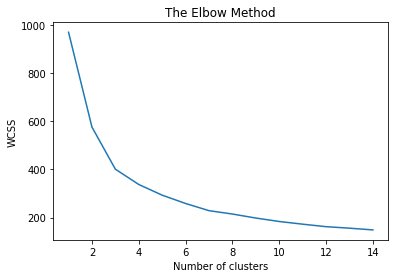

In [ ]:
Number_of_clusters(Kyiv_grouped1)

In [ ]:
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Kyiv_grouped1)


In [ ]:
Kyiv_grouped.drop('Cluster Labels', axis=1, inplace=True)
Kyiv_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
Kyiv_info = Kyiv_addresses[['RegionID', 'Address', 'Latitude', 'Longitude']]

In [ ]:
Kyiv_merged = Kyiv_info

Kyiv_merged = Kyiv_merged.join(Kyiv_grouped.set_index('RegionID'), on='RegionID')

In [ ]:
def create_map(kclusters, Kyiv_merged):
# create map
  map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

  # set color scheme for the clusters
  x = np.arange(kclusters)
  ys = [i + x + (i*x)**2 for i in range(kclusters)]
  colors_array = cm.coolwarm_r(np.linspace(0, 1, len(ys)))
  coolwarm = [colors.rgb2hex(i) for i in colors_array]

  # add markers to the map
  markers_colors = []
  for lat, lon, poi, cluster in zip(Kyiv_merged['Latitude'], Kyiv_merged['Longitude'], Kyiv_merged['Address'], Kyiv_merged['Cluster Labels']):
    if cluster>0:
      cluster = int(cluster)
    else:
      cluster = 0
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=coolwarm[cluster-1],
        fill=True,
        fill_color=coolwarm[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
  map_clusters

  return None

Feature group 2

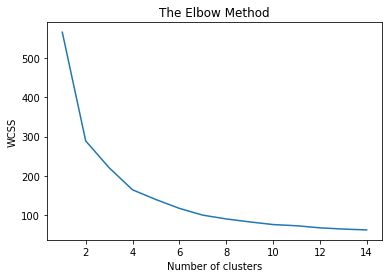

In [ ]:
Number_of_clusters(Kyiv_grouped2)

In [ ]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Kyiv_grouped2)

In [ ]:
Kyiv_grouped.drop('Cluster Labels', axis=1, inplace=True)
Kyiv_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
Kyiv_merged = Kyiv_info
Kyiv_merged = Kyiv_merged.join(Kyiv_grouped.set_index('RegionID'), on='RegionID')

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.coolwarm_r(np.linspace(0, 1, len(ys)))
coolwarm = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Kyiv_merged['Latitude'], Kyiv_merged['Longitude'], Kyiv_merged['Address'], Kyiv_merged['Cluster Labels']):
    if cluster>0:
      cluster = int(cluster)
    else:
      cluster = 0
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=coolwarm[cluster-1],
        fill=True,
        fill_color=coolwarm[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

create_map(kclusters, Kyiv_merged)

Feature group 3

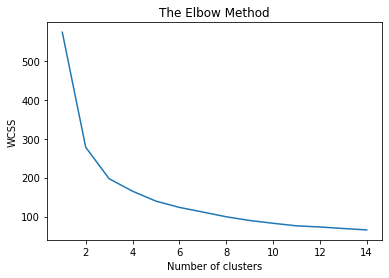

In [ ]:
Number_of_clusters(Kyiv_grouped3)

In [ ]:
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Kyiv_grouped3)

In [ ]:
Kyiv_grouped.drop('Cluster Labels', axis=1, inplace=True)
Kyiv_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
Kyiv_merged = Kyiv_info
Kyiv_merged = Kyiv_merged.join(Kyiv_grouped.set_index('RegionID'), on='RegionID')

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.coolwarm_r(np.linspace(0, 1, len(ys)))
coolwarm = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Kyiv_merged['Latitude'], Kyiv_merged['Longitude'], Kyiv_merged['Address'], Kyiv_merged['Cluster Labels']):
    if cluster>0:
      cluster = int(cluster)
    else:
      cluster = 0
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=coolwarm[cluster-1],
        fill=True,
        fill_color=coolwarm[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Feature group 4

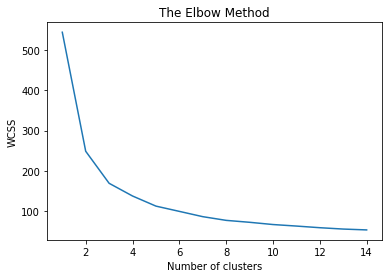

In [ ]:
Number_of_clusters(Kyiv_grouped4)

In [ ]:
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Kyiv_grouped4)

In [ ]:
Kyiv_grouped.drop('Cluster Labels', axis=1, inplace=True)
Kyiv_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
Kyiv_merged = Kyiv_info
Kyiv_merged = Kyiv_merged.join(Kyiv_grouped.set_index('RegionID'), on='RegionID')

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.coolwarm_r(np.linspace(0, 1, len(ys)))
coolwarm = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Kyiv_merged['Latitude'], Kyiv_merged['Longitude'], Kyiv_merged['Address'], Kyiv_merged['Cluster Labels']):
    if cluster>0:
      cluster = int(cluster)
    else:
      cluster = 0
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=coolwarm[cluster-1],
        fill=True,
        fill_color=coolwarm[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##Conclusion.

When people choose new housing, they often face two extremes:

* Detailed information on each available offer (there is too much information, such a volume is difficult to process)
* The information is aggregated by urban area. But within an urban area, both the real estate itself and the infrastructure can be so different that such recommendations become useless.

Using geodata clustering overcomes this problem. We can choose areas of any size and take into account all the features of each specific place.

The ability to choose criteria that are important for a particular person makes recommendation system more flexible and effective.

In the future, additional parameters can be added to the system, such as the crime rate, average performance in nearby schools, and so on.